In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from keras.layers import Dense, Dropout, BatchNormalization

# Load Data 

In [2]:
df = pd.read_csv('Preprocessed Data 3 Mar 2021.csv', index_col = 0)
df.head(5)

,Speed (km/h),Latitude coordinate (degrees),Longitude coordinate (degrees),Altitude (meters),Vertical accuracy (degrees),Horizontal accuracy (degrees),Course (degrees),Difcourse: course variation (degrees),Acceleration in X filtered by KF (Gs),Acceleration in Y filtered by KF (Gs),...,no speed limit,no lanes number,Type of road_motorway,Type of road_motorway_link,Type of road_primary,Type of road_primary_link,Type of road_tertiary_link,AGGRESSIVE,DROWSY,NORMAL
0,64.5,40.512924,-3.404577,612.5,4,5,331.9,0.000,-0.030,-0.015,...,0,0,0,0,0,0,0,0,0,1
1,63.6,40.513065,-3.404680,612.9,4,5,330.8,1.055,0.026,-0.012,...,0,0,0,0,0,0,0,0,0,1
2,62.2,40.513210,-3.404772,613.3,4,5,330.8,1.055,-0.021,-0.018,...,0,0,0,0,0,0,0,0,0,1
3,60.9,40.513348,-3.404868,613.5,3,5,330.1,0.703,0.025,0.006,...,0,0,0,0,0,0,0,0,0,1
4,61.2,40.513477,-3.404971,613.8,3,5,329.4,1.406,0.014,-0.031,...,0,0,0,0,0,0,0,0,0,1


# K-Fold Cross Validation

In [3]:
from sklearn.model_selection import KFold
X = df.iloc[:,:-3]
Y = df.iloc[:,-3:]
kf = KFold(n_splits=5, random_state=4, shuffle=True)

# Training

In [4]:
count = 0

for train_index, test_index in kf.split(X):
    print('Fold: ' + str(count))

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40)

    model = keras.Sequential()
    
    model.add(layers.LSTM(units=70, input_shape=(1,X_train.shape[2]), return_sequences=True, activation="tanh"))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    model.add(layers.LSTM(units=80, return_sequences=True, activation="tanh"))
    model.add(Dropout(0.05))
    model.add(BatchNormalization())
    
    model.add(layers.LSTM(units=70, return_sequences=True, activation="tanh"))
    model.add(Dropout(0.005))
    model.add(BatchNormalization())
    
    model.add(layers.LSTM(units=80, activation="tanh"))
    model.add(Dropout(0.001))
    model.add(BatchNormalization())
    
    model.add(Dense(3, 'softmax'))

    optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics = 'accuracy')

    model.summary()
    
    history = model.fit(X_train, Y_train, 
                    validation_data=(X_test, Y_test), 
                    #batch_size = 22,
                    callbacks=[early_stopping],
                    epochs=600)
    
    if count == 0:
        history_fold_0 = pd.DataFrame(history.history)
    elif count == 1:
        history_fold_1 = pd.DataFrame(history.history)
    elif count == 2:
        history_fold_2 = pd.DataFrame(history.history)
    elif count == 3:
        history_fold_3 = pd.DataFrame(history.history)
    elif count == 4:
        history_fold_4 = pd.DataFrame(history.history)
    
    count += 1

Fold: 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 70)             31080     
_________________________________________________________________
dropout (Dropout)            (None, 1, 70)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 70)             280       
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 80)             48320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 80)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 80)             320       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 70)      

769/769 [==============================] - 6s 8ms/step - loss: 0.1520 - accuracy: 0.9436 - val_loss: 0.1556 - val_accuracy: 0.9445
Epoch 44/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1461 - accuracy: 0.9462 - val_loss: 0.1452 - val_accuracy: 0.9506
Epoch 45/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1452 - accuracy: 0.9464 - val_loss: 0.1298 - val_accuracy: 0.9523
Epoch 46/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1447 - accuracy: 0.9455 - val_loss: 0.1422 - val_accuracy: 0.9502
Epoch 47/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1410 - accuracy: 0.9463 - val_loss: 0.1003 - val_accuracy: 0.9655
Epoch 48/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1435 - accuracy: 0.9460 - val_loss: 0.1110 - val_accuracy: 0.9592
Epoch 49/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1420 - accuracy: 0.9458 - val_loss: 0.1092 - val_accuracy: 0.9629
Epoch

Epoch 100/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1025 - accuracy: 0.9636 - val_loss: 0.0923 - val_accuracy: 0.9681
Epoch 101/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0978 - accuracy: 0.9649 - val_loss: 0.0834 - val_accuracy: 0.9730
Epoch 102/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1000 - accuracy: 0.9639 - val_loss: 0.0963 - val_accuracy: 0.9657
Epoch 103/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0962 - accuracy: 0.9640 - val_loss: 0.0860 - val_accuracy: 0.9745
Epoch 104/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0981 - accuracy: 0.9628 - val_loss: 0.0793 - val_accuracy: 0.9743
Epoch 105/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0966 - accuracy: 0.9649 - val_loss: 0.0920 - val_accuracy: 0.9701
Epoch 106/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1009 - accuracy: 0.9634 - val_loss: 0.0876 - val_ac

769/769 [==============================] - 6s 8ms/step - loss: 0.0827 - accuracy: 0.9700 - val_loss: 0.0714 - val_accuracy: 0.9777
Epoch 157/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0749 - accuracy: 0.9739 - val_loss: 0.0765 - val_accuracy: 0.9736
Epoch 158/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0807 - accuracy: 0.9710 - val_loss: 0.0789 - val_accuracy: 0.9736
Epoch 159/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0779 - accuracy: 0.9728 - val_loss: 0.0839 - val_accuracy: 0.9736
Epoch 160/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0768 - accuracy: 0.9732 - val_loss: 0.0826 - val_accuracy: 0.9727
Epoch 161/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0760 - accuracy: 0.9732 - val_loss: 0.0814 - val_accuracy: 0.9733
Epoch 162/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0752 - accuracy: 0.9731 - val_loss: 0.0860 - val_accuracy: 0.9746

769/769 [==============================] - 5s 6ms/step - loss: 0.0654 - accuracy: 0.9766 - val_loss: 0.0931 - val_accuracy: 0.9717
Epoch 213/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0625 - accuracy: 0.9787 - val_loss: 0.0885 - val_accuracy: 0.9733
Epoch 214/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0677 - accuracy: 0.9765 - val_loss: 0.0656 - val_accuracy: 0.9797
Epoch 215/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0621 - accuracy: 0.9776 - val_loss: 0.0820 - val_accuracy: 0.9746
Epoch 216/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0638 - accuracy: 0.9766 - val_loss: 0.0728 - val_accuracy: 0.9785
Epoch 217/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0690 - accuracy: 0.9759 - val_loss: 0.0757 - val_accuracy: 0.9758
Epoch 218/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0633 - accuracy: 0.9780 - val_loss: 0.0740 - val_accuracy: 0.9758

769/769 [==============================] - 5s 7ms/step - loss: 0.1672 - accuracy: 0.9382 - val_loss: 0.1234 - val_accuracy: 0.9514
Epoch 35/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1586 - accuracy: 0.9386 - val_loss: 0.1283 - val_accuracy: 0.9527
Epoch 36/600
769/769 [==============================] - 5s 7ms/step - loss: 0.1536 - accuracy: 0.9418 - val_loss: 0.1115 - val_accuracy: 0.9577
Epoch 37/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1584 - accuracy: 0.9400 - val_loss: 0.1296 - val_accuracy: 0.9501
Epoch 38/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1586 - accuracy: 0.9412 - val_loss: 0.1541 - val_accuracy: 0.9439
Epoch 39/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1606 - accuracy: 0.9398 - val_loss: 0.1192 - val_accuracy: 0.9562
Epoch 40/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1526 - accuracy: 0.9433 - val_loss: 0.1093 - val_accuracy: 0.9577
Epoch

Epoch 91/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0999 - accuracy: 0.9638 - val_loss: 0.0712 - val_accuracy: 0.9728
Epoch 92/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1037 - accuracy: 0.9623 - val_loss: 0.0842 - val_accuracy: 0.9693
Epoch 93/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0992 - accuracy: 0.9643 - val_loss: 0.0689 - val_accuracy: 0.9758
Epoch 94/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0949 - accuracy: 0.9658 - val_loss: 0.0983 - val_accuracy: 0.9663
Epoch 95/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1010 - accuracy: 0.9624 - val_loss: 0.0999 - val_accuracy: 0.9649
Epoch 96/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1031 - accuracy: 0.9615 - val_loss: 0.1209 - val_accuracy: 0.9561
Epoch 97/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0948 - accuracy: 0.9659 - val_loss: 0.0969 - val_accuracy:

769/769 [==============================] - 6s 8ms/step - loss: 0.0760 - accuracy: 0.9730 - val_loss: 0.0574 - val_accuracy: 0.9823
Epoch 148/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0784 - accuracy: 0.9717 - val_loss: 0.0669 - val_accuracy: 0.9777
Epoch 149/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0767 - accuracy: 0.9726 - val_loss: 0.0615 - val_accuracy: 0.9782
Epoch 150/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0723 - accuracy: 0.9736 - val_loss: 0.0681 - val_accuracy: 0.9759
Epoch 151/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0789 - accuracy: 0.9722 - val_loss: 0.0631 - val_accuracy: 0.9782
Epoch 152/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0805 - accuracy: 0.9719 - val_loss: 0.0652 - val_accuracy: 0.9792
Epoch 153/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0771 - accuracy: 0.9734 - val_loss: 0.0792 - val_accuracy: 0.9738

769/769 [==============================] - 5s 7ms/step - loss: 0.0679 - accuracy: 0.9753 - val_loss: 0.0545 - val_accuracy: 0.9829
Epoch 204/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0638 - accuracy: 0.9774 - val_loss: 0.0658 - val_accuracy: 0.9795
Epoch 205/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0601 - accuracy: 0.9782 - val_loss: 0.0564 - val_accuracy: 0.9829
Epoch 206/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0617 - accuracy: 0.9784 - val_loss: 0.0676 - val_accuracy: 0.9785
Epoch 207/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0666 - accuracy: 0.9754 - val_loss: 0.0827 - val_accuracy: 0.9712
Epoch 208/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0654 - accuracy: 0.9773 - val_loss: 0.0615 - val_accuracy: 0.9800
Epoch 209/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0660 - accuracy: 0.9769 - val_loss: 0.0642 - val_accuracy: 0.9793

769/769 [==============================] - 5s 7ms/step - loss: 0.0544 - accuracy: 0.9802 - val_loss: 0.0585 - val_accuracy: 0.9816
Epoch 260/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0557 - accuracy: 0.9811 - val_loss: 0.0593 - val_accuracy: 0.9800
Epoch 261/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0507 - accuracy: 0.9809 - val_loss: 0.0515 - val_accuracy: 0.9854
Epoch 262/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0556 - accuracy: 0.9805 - val_loss: 0.0512 - val_accuracy: 0.9829
Epoch 263/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0557 - accuracy: 0.9799 - val_loss: 0.0568 - val_accuracy: 0.9826
Epoch 264/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0539 - accuracy: 0.9810 - val_loss: 0.0653 - val_accuracy: 0.9802
Epoch 265/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0554 - accuracy: 0.9813 - val_loss: 0.0650 - val_accuracy: 0.9805

769/769 [==============================] - 7s 9ms/step - loss: 0.0468 - accuracy: 0.9838 - val_loss: 0.0506 - val_accuracy: 0.9831
Epoch 316/600
769/769 [==============================] - 7s 10ms/step - loss: 0.0507 - accuracy: 0.9811 - val_loss: 0.0556 - val_accuracy: 0.9829
Epoch 317/600
769/769 [==============================] - 7s 9ms/step - loss: 0.0487 - accuracy: 0.9828 - val_loss: 0.0599 - val_accuracy: 0.9828
Epoch 318/600
769/769 [==============================] - 7s 10ms/step - loss: 0.0521 - accuracy: 0.9828 - val_loss: 0.0660 - val_accuracy: 0.9790
Epoch 319/600
769/769 [==============================] - 9s 12ms/step - loss: 0.0484 - accuracy: 0.9837 - val_loss: 0.0552 - val_accuracy: 0.9841
Epoch 320/600
769/769 [==============================] - 8s 11ms/step - loss: 0.0442 - accuracy: 0.9842 - val_loss: 0.0709 - val_accuracy: 0.9800
Epoch 321/600
769/769 [==============================] - 7s 9ms/step - loss: 0.0526 - accuracy: 0.9819 - val_loss: 0.0498 - val_accuracy: 0.

769/769 [==============================] - 7s 9ms/step - loss: 0.2698 - accuracy: 0.8930 - val_loss: 0.2210 - val_accuracy: 0.9164
Epoch 12/600
769/769 [==============================] - 7s 9ms/step - loss: 0.2575 - accuracy: 0.8974 - val_loss: 0.1902 - val_accuracy: 0.9263
Epoch 13/600
769/769 [==============================] - 7s 9ms/step - loss: 0.2507 - accuracy: 0.8998 - val_loss: 0.1812 - val_accuracy: 0.9318
Epoch 14/600
769/769 [==============================] - 7s 9ms/step - loss: 0.2473 - accuracy: 0.9025 - val_loss: 0.2639 - val_accuracy: 0.9000
Epoch 15/600
769/769 [==============================] - 7s 9ms/step - loss: 0.2365 - accuracy: 0.9081 - val_loss: 0.1923 - val_accuracy: 0.9262
Epoch 16/600
769/769 [==============================] - 7s 9ms/step - loss: 0.2306 - accuracy: 0.9105 - val_loss: 0.1724 - val_accuracy: 0.9296
Epoch 17/600
769/769 [==============================] - 7s 9ms/step - loss: 0.2216 - accuracy: 0.9139 - val_loss: 0.1745 - val_accuracy: 0.9346
Epoch

Epoch 68/600
769/769 [==============================] - 9s 11ms/step - loss: 0.1186 - accuracy: 0.9553 - val_loss: 0.0860 - val_accuracy: 0.9702
Epoch 69/600
769/769 [==============================] - 10s 13ms/step - loss: 0.1188 - accuracy: 0.9568 - val_loss: 0.0902 - val_accuracy: 0.9696
Epoch 70/600
769/769 [==============================] - 9s 12ms/step - loss: 0.1154 - accuracy: 0.9578 - val_loss: 0.0922 - val_accuracy: 0.9693
Epoch 71/600
769/769 [==============================] - 7s 9ms/step - loss: 0.1160 - accuracy: 0.9561 - val_loss: 0.0812 - val_accuracy: 0.9706
Epoch 72/600
769/769 [==============================] - 8s 10ms/step - loss: 0.1176 - accuracy: 0.9583 - val_loss: 0.1066 - val_accuracy: 0.9623
Epoch 73/600
769/769 [==============================] - 7s 9ms/step - loss: 0.1123 - accuracy: 0.9582 - val_loss: 0.1082 - val_accuracy: 0.9634
Epoch 74/600
769/769 [==============================] - 8s 10ms/step - loss: 0.1178 - accuracy: 0.9572 - val_loss: 0.0831 - val_acc

769/769 [==============================] - 10s 13ms/step - loss: 0.0903 - accuracy: 0.9667 - val_loss: 0.0679 - val_accuracy: 0.9767
Epoch 125/600
769/769 [==============================] - 10s 13ms/step - loss: 0.0838 - accuracy: 0.9699 - val_loss: 0.0761 - val_accuracy: 0.9751
Epoch 126/600
769/769 [==============================] - 10s 13ms/step - loss: 0.0879 - accuracy: 0.9669 - val_loss: 0.0784 - val_accuracy: 0.9769
Epoch 127/600
769/769 [==============================] - 10s 12ms/step - loss: 0.0866 - accuracy: 0.9690 - val_loss: 0.0810 - val_accuracy: 0.9740
Epoch 128/600
769/769 [==============================] - 10s 13ms/step - loss: 0.0835 - accuracy: 0.9702 - val_loss: 0.0776 - val_accuracy: 0.9736
Epoch 129/600
769/769 [==============================] - 9s 11ms/step - loss: 0.0895 - accuracy: 0.9681 - val_loss: 0.0885 - val_accuracy: 0.9691
Epoch 130/600
769/769 [==============================] - 8s 11ms/step - loss: 0.0888 - accuracy: 0.9673 - val_loss: 0.0767 - val_accu

769/769 [==============================] - 8s 10ms/step - loss: 0.0703 - accuracy: 0.9748 - val_loss: 0.0695 - val_accuracy: 0.9798
Epoch 181/600
769/769 [==============================] - 8s 10ms/step - loss: 0.0728 - accuracy: 0.9738 - val_loss: 0.0655 - val_accuracy: 0.9803
Epoch 182/600
769/769 [==============================] - 8s 10ms/step - loss: 0.0711 - accuracy: 0.9753 - val_loss: 0.0703 - val_accuracy: 0.9780
Epoch 183/600
769/769 [==============================] - 8s 10ms/step - loss: 0.0722 - accuracy: 0.9747 - val_loss: 0.0527 - val_accuracy: 0.9865
Epoch 184/600
769/769 [==============================] - 8s 11ms/step - loss: 0.0713 - accuracy: 0.9742 - val_loss: 0.0624 - val_accuracy: 0.9821
Epoch 185/600
769/769 [==============================] - 9s 11ms/step - loss: 0.0709 - accuracy: 0.9750 - val_loss: 0.0554 - val_accuracy: 0.9841
Epoch 186/600
769/769 [==============================] - 8s 10ms/step - loss: 0.0695 - accuracy: 0.9758 - val_loss: 0.0618 - val_accuracy:

Epoch 236/600
769/769 [==============================] - 8s 11ms/step - loss: 0.0603 - accuracy: 0.9806 - val_loss: 0.0613 - val_accuracy: 0.9826
Epoch 237/600
769/769 [==============================] - 8s 11ms/step - loss: 0.0607 - accuracy: 0.9787 - val_loss: 0.0673 - val_accuracy: 0.9811
Epoch 238/600
769/769 [==============================] - 8s 11ms/step - loss: 0.0588 - accuracy: 0.9789 - val_loss: 0.0647 - val_accuracy: 0.9802
Epoch 239/600
769/769 [==============================] - 9s 12ms/step - loss: 0.0606 - accuracy: 0.9794 - val_loss: 0.0537 - val_accuracy: 0.9854
Epoch 240/600
769/769 [==============================] - 9s 12ms/step - loss: 0.0584 - accuracy: 0.9795 - val_loss: 0.0550 - val_accuracy: 0.9849
Epoch 241/600
769/769 [==============================] - 9s 12ms/step - loss: 0.0609 - accuracy: 0.9797 - val_loss: 0.0542 - val_accuracy: 0.9847
Epoch 242/600
769/769 [==============================] - 9s 12ms/step - loss: 0.0550 - accuracy: 0.9807 - val_loss: 0.0590 -

769/769 [==============================] - 7s 9ms/step - loss: 0.1912 - accuracy: 0.9270 - val_loss: 0.1303 - val_accuracy: 0.9532
Epoch 24/600
769/769 [==============================] - 8s 10ms/step - loss: 0.2015 - accuracy: 0.9201 - val_loss: 0.1498 - val_accuracy: 0.9426
Epoch 25/600
769/769 [==============================] - 7s 10ms/step - loss: 0.1920 - accuracy: 0.9252 - val_loss: 0.1536 - val_accuracy: 0.9414
Epoch 26/600
769/769 [==============================] - 8s 11ms/step - loss: 0.1864 - accuracy: 0.9302 - val_loss: 0.1433 - val_accuracy: 0.9429
Epoch 27/600
769/769 [==============================] - 8s 10ms/step - loss: 0.1898 - accuracy: 0.9249 - val_loss: 0.1498 - val_accuracy: 0.9427
Epoch 28/600
769/769 [==============================] - 8s 10ms/step - loss: 0.1771 - accuracy: 0.9323 - val_loss: 0.1129 - val_accuracy: 0.9588
Epoch 29/600
769/769 [==============================] - 8s 10ms/step - loss: 0.1819 - accuracy: 0.9288 - val_loss: 0.1321 - val_accuracy: 0.9493

769/769 [==============================] - 8s 11ms/step - loss: 0.1169 - accuracy: 0.9563 - val_loss: 0.0749 - val_accuracy: 0.9763
Epoch 80/600
769/769 [==============================] - 9s 12ms/step - loss: 0.1102 - accuracy: 0.9598 - val_loss: 0.0969 - val_accuracy: 0.9668
Epoch 81/600
769/769 [==============================] - 8s 10ms/step - loss: 0.1135 - accuracy: 0.9580 - val_loss: 0.0697 - val_accuracy: 0.9741
Epoch 82/600
769/769 [==============================] - 8s 10ms/step - loss: 0.1083 - accuracy: 0.9590 - val_loss: 0.0850 - val_accuracy: 0.9717
Epoch 83/600
769/769 [==============================] - 8s 10ms/step - loss: 0.1063 - accuracy: 0.9608 - val_loss: 0.0766 - val_accuracy: 0.9753
Epoch 84/600
769/769 [==============================] - 8s 10ms/step - loss: 0.1117 - accuracy: 0.9602 - val_loss: 0.0898 - val_accuracy: 0.9696
Epoch 85/600
769/769 [==============================] - 7s 10ms/step - loss: 0.1054 - accuracy: 0.9620 - val_loss: 0.0671 - val_accuracy: 0.978

769/769 [==============================] - 8s 10ms/step - loss: 0.0829 - accuracy: 0.9705 - val_loss: 0.0616 - val_accuracy: 0.9826
Epoch 136/600
769/769 [==============================] - 7s 9ms/step - loss: 0.0773 - accuracy: 0.9721 - val_loss: 0.0776 - val_accuracy: 0.9763
Epoch 137/600
769/769 [==============================] - 7s 9ms/step - loss: 0.0822 - accuracy: 0.9704 - val_loss: 0.0700 - val_accuracy: 0.9787
Epoch 138/600
769/769 [==============================] - 7s 9ms/step - loss: 0.0868 - accuracy: 0.9690 - val_loss: 0.0642 - val_accuracy: 0.9803
Epoch 139/600
769/769 [==============================] - 7s 9ms/step - loss: 0.0872 - accuracy: 0.9705 - val_loss: 0.0666 - val_accuracy: 0.9789
Epoch 140/600
769/769 [==============================] - 7s 10ms/step - loss: 0.0765 - accuracy: 0.9728 - val_loss: 0.0736 - val_accuracy: 0.9774
Epoch 141/600
769/769 [==============================] - 7s 10ms/step - loss: 0.0857 - accuracy: 0.9695 - val_loss: 0.0583 - val_accuracy: 0.9

769/769 [==============================] - 9s 11ms/step - loss: 0.2179 - accuracy: 0.9157 - val_loss: 0.1782 - val_accuracy: 0.9340
Epoch 18/600
769/769 [==============================] - 8s 11ms/step - loss: 0.2120 - accuracy: 0.9179 - val_loss: 0.1557 - val_accuracy: 0.9416
Epoch 19/600
769/769 [==============================] - 8s 11ms/step - loss: 0.2090 - accuracy: 0.9183 - val_loss: 0.1609 - val_accuracy: 0.9379
Epoch 20/600
769/769 [==============================] - 9s 11ms/step - loss: 0.1995 - accuracy: 0.9231 - val_loss: 0.1763 - val_accuracy: 0.9317
Epoch 21/600
769/769 [==============================] - 9s 11ms/step - loss: 0.2022 - accuracy: 0.9220 - val_loss: 0.1580 - val_accuracy: 0.9418
Epoch 22/600
769/769 [==============================] - 9s 11ms/step - loss: 0.1945 - accuracy: 0.9240 - val_loss: 0.1488 - val_accuracy: 0.9444
Epoch 23/600
769/769 [==============================] - 9s 11ms/step - loss: 0.1912 - accuracy: 0.9259 - val_loss: 0.1687 - val_accuracy: 0.936

Epoch 74/600
769/769 [==============================] - 5s 7ms/step - loss: 0.1099 - accuracy: 0.9596 - val_loss: 0.0930 - val_accuracy: 0.9712
Epoch 75/600
769/769 [==============================] - 5s 7ms/step - loss: 0.1124 - accuracy: 0.9571 - val_loss: 0.0976 - val_accuracy: 0.9675
Epoch 76/600
769/769 [==============================] - 5s 7ms/step - loss: 0.1142 - accuracy: 0.9576 - val_loss: 0.1021 - val_accuracy: 0.9626
Epoch 77/600
769/769 [==============================] - 5s 7ms/step - loss: 0.1181 - accuracy: 0.9566 - val_loss: 0.0968 - val_accuracy: 0.9670
Epoch 78/600
769/769 [==============================] - 5s 7ms/step - loss: 0.1074 - accuracy: 0.9610 - val_loss: 0.1044 - val_accuracy: 0.9608
Epoch 79/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1120 - accuracy: 0.9590 - val_loss: 0.1175 - val_accuracy: 0.9611
Epoch 80/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1152 - accuracy: 0.9567 - val_loss: 0.0953 - val_accuracy:

Epoch 131/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0807 - accuracy: 0.9708 - val_loss: 0.0883 - val_accuracy: 0.9743
Epoch 132/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0847 - accuracy: 0.9686 - val_loss: 0.0890 - val_accuracy: 0.9717
Epoch 133/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0858 - accuracy: 0.9699 - val_loss: 0.0815 - val_accuracy: 0.9740
Epoch 134/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0861 - accuracy: 0.9686 - val_loss: 0.0724 - val_accuracy: 0.9774
Epoch 135/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0817 - accuracy: 0.9708 - val_loss: 0.0782 - val_accuracy: 0.9743
Epoch 136/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0820 - accuracy: 0.9708 - val_loss: 0.0879 - val_accuracy: 0.9728
Epoch 137/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0856 - accuracy: 0.9685 - val_loss: 0.0779 - val_ac

# Final Result

### Fold 1

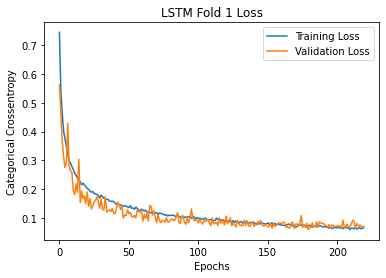

In [5]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_0.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('LSTM Fold 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

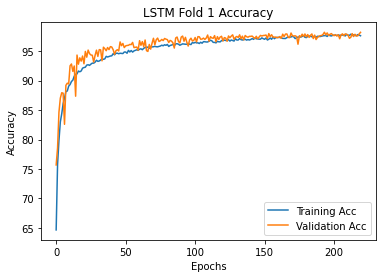

In [6]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_0.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('LSTM Fold 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 2

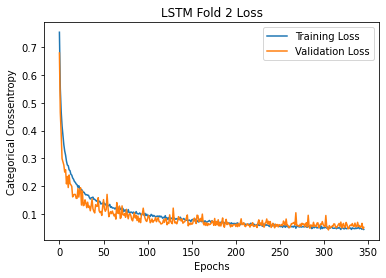

In [7]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_1.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('LSTM Fold 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

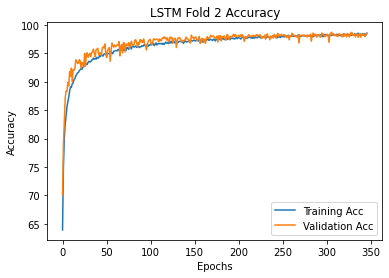

In [8]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_1.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('LSTM Fold 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 3

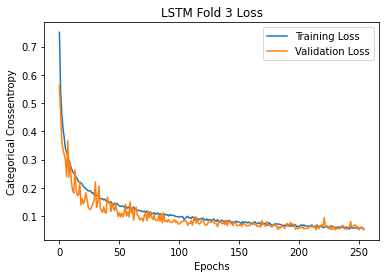

In [9]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_2.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('LSTM Fold 3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

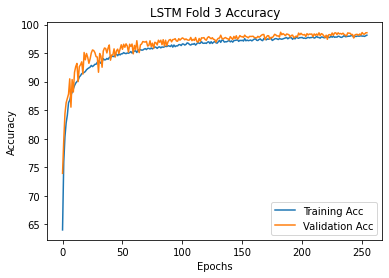

In [10]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_2.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('LSTM Fold 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 4

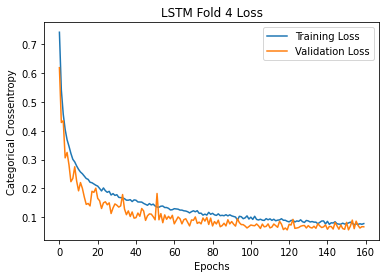

In [11]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_3.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('LSTM Fold 4 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

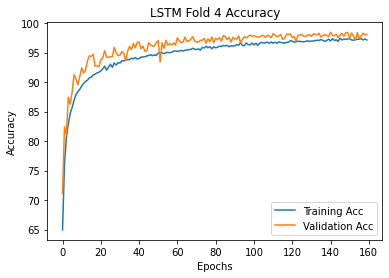

In [12]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_3.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('LSTM Fold 4 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 5

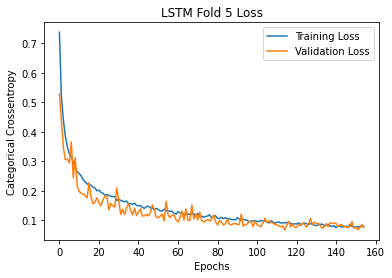

In [13]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_4.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('LSTM Fold 5 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

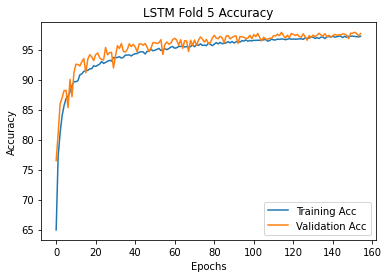

In [14]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_4.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('LSTM Fold 5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Final Accuracy and Loss

In [15]:
final_result = pd.concat([history_fold_0[-1:],
                          history_fold_1[-1:],
                          history_fold_2[-1:],
                          history_fold_3[-1:],
                          history_fold_4[-1:],
                         ])
final_result.columns = ['Last Training Loss (Crossentropy)', 'Last Training Accuracy', 'Last Validation Loss (Crossentropy)', 'Last Validation Accuracy']
final_result = final_result.reset_index(drop = True)
final_result.index += 1 
final_result.index.name = 'Fold'
final_result['Last Training Accuracy'] *= 100
final_result['Last Validation Accuracy'] *= 100
final_result['Last Training Loss (Crossentropy)'] = final_result['Last Training Loss (Crossentropy)'].round(5)
final_result['Last Validation Loss (Crossentropy)'] = final_result['Last Validation Loss (Crossentropy)'].round(5)
final_result['Last Training Accuracy'] = final_result['Last Training Accuracy'].round(2)
final_result['Last Validation Accuracy'] = final_result['Last Validation Accuracy'].round(2)

final_result

,Last Training Loss (Crossentropy),Last Training Accuracy,Last Validation Loss (Crossentropy),Last Validation Accuracy
Fold,,,,
1,0.06954,97.60,0.06499,98.18
2,0.04444,98.58,0.05206,98.49
3,0.05208,98.14,0.05504,98.57
4,0.07789,97.13,0.06676,98.05
5,0.07762,97.23,0.07603,97.69


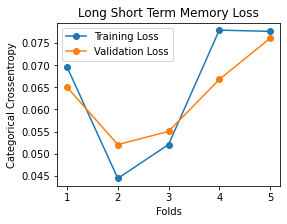

In [16]:
plt.figure(figsize = [4,3])
plt.plot(final_result.loc[:, ['Last Training Loss (Crossentropy)', 'Last Validation Loss (Crossentropy)']],'o-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Long Short Term Memory Loss')
plt.xticks(np.arange(1,6,1))
plt.xlabel('Folds')
plt.ylabel('Categorical Crossentropy')
plt.show()

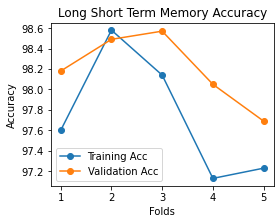

In [17]:
plt.figure(figsize = [4,3])
plt.plot(final_result.loc[:, ['Last Training Accuracy', 'Last Validation Accuracy']],'o-')
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('Long Short Term Memory Accuracy')
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.show()